<a href="https://colab.research.google.com/github/zMo0/APS360-project/blob/main/ANNw_final_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((180, 320)),
                                transforms.Grayscale(),
                                transforms.Normalize((0.5),(0.5))])

dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/final_dataset/train',
                                           transform = transform)
valset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/final_dataset/val',
                                           transform = transform)
testset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/final_dataset/test',
                                           transform = transform)

In [7]:
print(len(dataset))
for img, label in iter(dataset):
  print(label)
  print(img.size())
  break


6000
0
torch.Size([1, 180, 320])


In [16]:
print(len(valset))

1500


In [17]:
print(len(testset))

1500


In [10]:
import matplotlib.pyplot as plt

In [11]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = 'ANN'
        self.l1 = nn.Linear(180*320, 200)
        self.l2 = nn.Linear(200, 5)

    def forward(self, x):
        flattened = x.view(-1, 180*320)
        x = F.relu(self.l1(flattened))
        x = self.l2(x)

        return x

In [12]:
use_cuda = False 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [13]:
def training(model, data, val_data, batch_size = 64, epochs = 10, lr = 0.001, momentum = 0.9):
  #split into batches
  train = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle = True)
  val = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = True)

  #loss function
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)

  #store stats
  iters, losses, train_acc, val_acc = [], [], [], []

  #train for specified number of epochs
  for epoch in range(epochs):
    #print ('epoch number', epoch)
    n = 0
    # train each batch\\
    for i, data in enumerate(train,0):
      imgs, label = data
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          label = label.cuda()
      #############################################     

      #print ('batch number', n)
      #forward pass
      #print(imgs.size())
      #print(label.size())
      out = model(imgs)
      loss = criterion(out, label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      n+=1

    # save the current training information
    iters.append(epoch)
    losses.append(float(loss)/batch_size)                         # compute *average* loss
    train_acc.append(get_accuracy(model, train, val, train=True)) # compute training accuracy
    val_acc.append(get_accuracy(model, train, val, train=False))  # compute validation accuracy
    model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, lr, epoch)
    torch.save(model.state_dict(), model_path)
   
    
  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))


In [14]:
def get_accuracy(model, train_loader, valid_loader, train=False):
    if train:
        data = train_loader
    else:
        data = valid_loader
   

    correct = 0
    total = 0
    for imgs, labels in data:
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################   
      output = model(imgs)
        
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
        
      total += imgs.shape[0]
        
    return correct / total

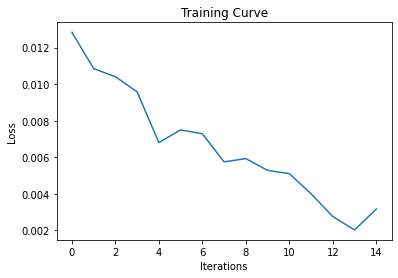

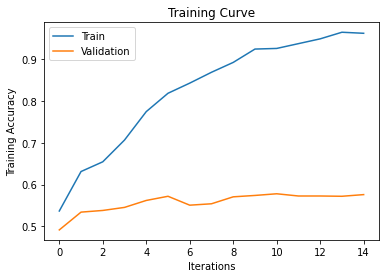

Final Training Accuracy: 0.9628333333333333
Final Validation Accuracy: 0.576


In [15]:
# try the training function
model = ANN()
training(model, dataset, valset, batch_size = 100, epochs = 15, lr = 0.001, momentum = 0.9)

In [22]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle = True)
print("Test accuracy is: ", get_accuracy(model, testloader, testloader, train=False))

Test accuracy is:  0.3333333333333333
